In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/abalone.csv"
df = pd.read_csv(url)

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

# 특성 엔지니어링
df['Length_to_Diameter'] = df['Length'] / df['Diameter']
df['Weight_to_Length'] = df['Whole_weight'] / df['Length']
df['Shell_weight_ratio'] = df['Shell_weight'] / df['Whole_weight']
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']

X = df.drop(['id', 'Rings'], axis=1)
y = df['Rings']

In [39]:
# 분류를 위한 타겟 변수 범주화
y_class = pd.cut(y, bins=[0, 7, 10, 15, 30], labels=[0, 1, 2, 3]).astype(int)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [43]:
# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 특성 선택
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [45]:
# 1. 머신러닝 - Random Forest (분류)
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_clf = GridSearchCV(rf_clf, param_grid_clf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_clf.fit(X_train_selected, y_train_class)

best_rf_clf = grid_search_clf.best_estimator_
y_pred_rf_clf = best_rf_clf.predict(X_test_selected)
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_clf)
print(f"Random Forest 분류 테스트 정확도: {accuracy_rf:.4f}")

Random Forest 분류 테스트 정확도: 0.6328


In [47]:
# 2. 머신러닝 - Random Forest (회귀)
param_grid_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_reg = RandomForestRegressor(random_state=42)
grid_search_reg = GridSearchCV(rf_reg, param_grid_reg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_reg.fit(X_train_selected, y_train)

best_rf_reg = grid_search_reg.best_estimator_
y_pred_rf_reg = best_rf_reg.predict(X_test_selected)
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
r2_rf = r2_score(y_test, y_pred_rf_reg)
print(f"Random Forest 회귀 테스트 MSE: {mse_rf:.4f}")
print(f"Random Forest 회귀 테스트 R2: {r2_rf:.4f}")

Random Forest 회귀 테스트 MSE: 5.1238
Random Forest 회귀 테스트 R2: 0.5267


In [71]:
# 3. 딥러닝 - 분류 모델
inputs = Input(shape=(X_train_selected.shape[1],))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model_clf = tf.keras.Model(inputs=inputs, outputs=outputs)

lr_schedule_clf = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
early_stopping_clf = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
optimizer_clf = Adam(learning_rate=0.001)
model_clf.compile(optimizer=optimizer_clf, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_clf = model_clf.fit(
    X_train_selected, y_train_class,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_schedule_clf, early_stopping_clf],
    verbose=0
)

y_pred_dl_clf = np.argmax(model_clf.predict(X_test_selected), axis=1)
accuracy_dl = accuracy_score(y_test_class, y_pred_dl_clf)
print(f"딥러닝 분류 모델 테스트 정확도: {accuracy_dl:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
딥러닝 분류 모델 테스트 정확도: 0.6435


In [72]:
# 4. 딥러닝 - 회귀 모델
inputs = Input(shape=(X_train_selected.shape[1],))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)

model_reg = tf.keras.Model(inputs=inputs, outputs=outputs)

lr_schedule_reg = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
early_stopping_reg = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
optimizer_reg = Adam(learning_rate=0.001)
model_reg.compile(optimizer=optimizer_reg, loss='mean_squared_error', metrics=['mae'])

history_reg = model_reg.fit(
    X_train_selected, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_schedule_reg, early_stopping_reg],
    verbose=0
)

y_pred_dl_reg = model_reg.predict(X_test_selected).flatten()
mse_dl = mean_squared_error(y_test, y_pred_dl_reg)
r2_dl = r2_score(y_test, y_pred_dl_reg)
print(f"딥러닝 회귀 모델 테스트 MSE: {mse_dl:.4f}")
print(f"딥러닝 회귀 모델 테스트 R2: {r2_dl:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
딥러닝 회귀 모델 테스트 MSE: 4.7348
딥러닝 회귀 모델 테스트 R2: 0.5626


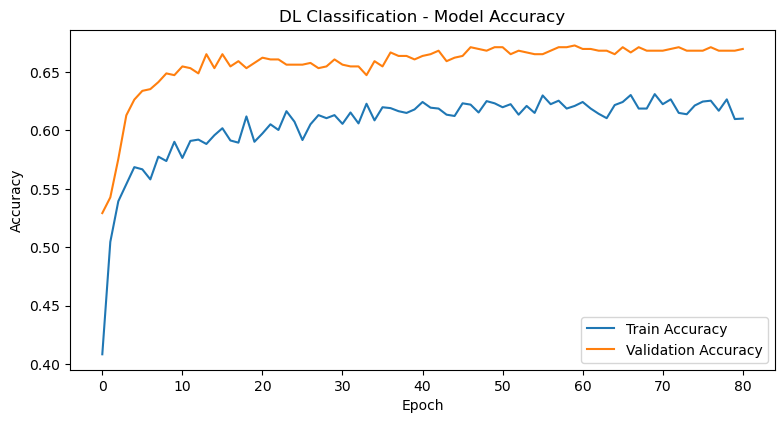

In [75]:
# 시각화
plt.figure(figsize=(20, 15))

# 분류 모델 정확도
plt.subplot(3, 2, 1)
plt.plot(history_clf.history['accuracy'], label='Train Accuracy')
plt.plot(history_clf.history['val_accuracy'], label='Validation Accuracy')
plt.title('DL Classification - Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

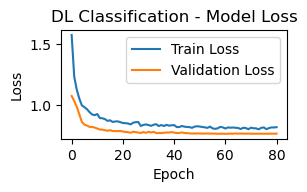

In [77]:
# 분류 모델 손실
plt.subplot(3, 2, 2)
plt.plot(history_clf.history['loss'], label='Train Loss')
plt.plot(history_clf.history['val_loss'], label='Validation Loss')
plt.title('DL Classification - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

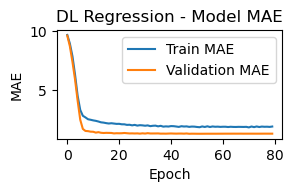

In [79]:
# 회귀 모델 MAE
plt.subplot(3, 2, 3)
plt.plot(history_reg.history['mae'], label='Train MAE')
plt.plot(history_reg.history['val_mae'], label='Validation MAE')
plt.title('DL Regression - Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

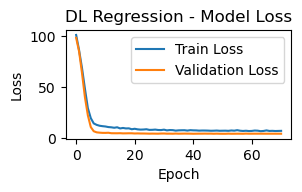

In [63]:
# 회귀 모델 손실
plt.subplot(3, 2, 4)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('DL Regression - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Text(50.722222222222214, 0.5, 'Actual')

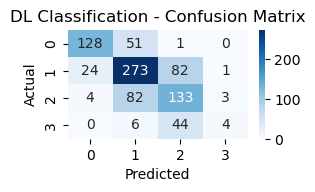

In [81]:
# 분류 모델 혼동 행렬
plt.subplot(3, 2, 5)
cm = confusion_matrix(y_test_class, y_pred_dl_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('DL Classification - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

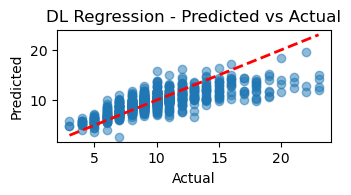

In [83]:
# 회귀 모델 예측 vs 실제 값
plt.subplot(3, 2, 6)
plt.scatter(y_test, y_pred_dl_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('DL Regression - Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

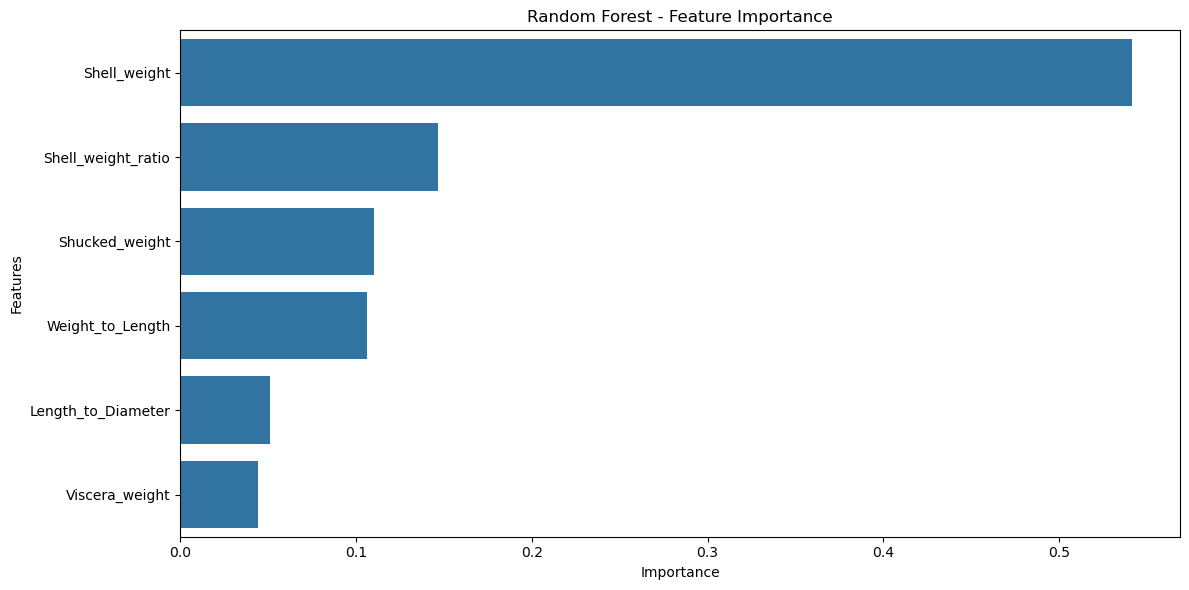

In [85]:
# 특성 중요도 시각화 (Random Forest)
plt.figure(figsize=(12, 6))
feature_importance = best_rf_reg.feature_importances_
feature_names = X.columns[selector.get_support()]
feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()